In [1]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader

In [ ]:
class ROIDataset(Dataset):
    def __init__(self, signal_noise_path, roi_path, indices):
        self.signal_noise = np.memmap(signal_noise_path, dtype=np.float32, mode='r', shape=(1000, 1280, 2128))
        self.roi = np.load(roi_path, mmap_mode='r')  # mmap for efficiency
        self.indices = indices  # Define which samples to use

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        index = self.indices[idx]
        x = torch.tensor(self.signal_noise[index], dtype=torch.float32).unsqueeze(0)  # Add channel dim
        y = torch.tensor(self.roi[index], dtype=torch.float32).unsqueeze(0)
        return x, y

# Create dataset splits
train_indices = list(range(0, 700))
val_indices = list(range(700, 850))
test_indices = list(range(850, 1000))

train_dataset = ROIDataset("noise.raw", "roi.npy", train_indices)
val_dataset = ROIDataset("noise.raw", "roi.npy", val_indices)
test_dataset = ROIDataset("noise.raw", "roi.npy", test_indices)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
import torch.nn as nn
import torch.optim as optim

In [ ]:
class ROIFinder(nn.Module):
    def __init__(self):
        super(ROIFinder, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 1, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.sigmoid(self.conv3(x))  # Binary classification (signal present or not)
        return x

model = ROIFinder().cuda()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
import matplotlib.pyplot as plt

def train_roi_finder(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.cuda(), targets.cuda()
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = evaluate(model, val_loader, criterion)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Plot Training vs Validation Loss
    plt.plot(range(1, epochs+1), train_losses, label="Train Loss")
    plt.plot(range(1, epochs+1), val_losses, label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training & Validation Loss Over Epochs")
    plt.show()

def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
    return total_loss / len(loader)

# Run training
train_roi_finder(model, train_loader, val_loader, criterion, optimizer, epochs=10)

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder().cuda()
ae_criterion = nn.MSELoss()
ae_optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

In [ ]:
def train_autoencoder(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for inputs, _ in train_loader:  # Only need input (no target)
            inputs = inputs.cuda()
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, inputs)  # Try to reconstruct the input
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

        val_loss = evaluate(model, val_loader, criterion)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {total_loss/len(train_loader)}, Val Loss: {val_loss}")

train_autoencoder(autoencoder, train_loader, val_loader, ae_criterion, ae_optimizer, epochs=10)

In [ ]:
import matplotlib.pyplot as plt

def visualize_reconstruction(model, test_loader):
    model.eval()
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.cuda()
            outputs = model(inputs)
            break  # Take the first batch

    inputs = inputs.cpu().numpy()[0, 0]  # Convert back to NumPy
    outputs = outputs.cpu().numpy()[0, 0]

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Noisy Input")
    plt.imshow(inputs, cmap='gray')

    plt.subplot(1, 2, 2)
    plt.title("Reconstructed Signal")
    plt.imshow(outputs, cmap='gray')

    plt.show()

visualize_reconstruction(autoencoder, test_loader)

In [ ]:
## Below we train on TPC 0 Col Plane data only ##

In [35]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import os

In [36]:
# Load memmap files
signal_memmap = np.memmap("signal.raw", dtype=np.float32, mode='r', shape=(1000, 1280, 2128))
noise_memmap = np.memmap("noise.raw", dtype=np.float32, mode='r', shape=(1000, 1280, 2128))
roi_memmap = np.load("roi.npy")  # ROI is loaded directly

# Extract only TPC 0 Plane Z (channels 800-1039)
signal_data = signal_memmap[:, 800:1040, :]
noise_data = noise_memmap[:, 800:1040, :]
roi_data = roi_memmap[:, 800:1040, :]

# Normalize input (optional, based on data distribution)
signal_data = (signal_data - np.mean(signal_data)) / np.std(signal_data)
noise_data = (noise_data - np.mean(noise_data)) / np.std(noise_data)

# Reshape data to treat each channel separately
# X: Input (Noise+Signal), Y: Output (ROI mask)
X = noise_data[:, np.newaxis, :, :]  # Shape: (1000, 1, 240, 2128) -- note (1000 events, 1 image channel i.e. gray, 240 channels, 2128 time ticks)
Y = roi_data[:, np.newaxis, :, :]    # Shape: (1000, 1, 240, 2128)

In [37]:
class ROIDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# Define dataset
dataset = ROIDataset(X, Y)

# Train-validation-test split
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

#train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Have train, val, test in order.
train_dataset = torch.utils.data.Subset(dataset, range(train_size))
val_dataset = torch.utils.data.Subset(dataset, range(train_size,train_size+val_size))
test_dataset = torch.utils.data.Subset(dataset, range(train_size+val_size,train_size+val_size+test_size))

# Create DataLoader
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [38]:
model_index = 1
kernel_size = 5
activation = "relu"

class ROIFinder2D(nn.Module):
    def __init__(self):
        super(ROIFinder2D, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=kernel_size, padding=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=kernel_size, padding=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=kernel_size, padding=2)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=kernel_size, padding=2)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=kernel_size, padding=2)
        self.upconv2 = nn.ConvTranspose2d(64, 32, kernel_size=kernel_size, padding=2)
        self.upconv3 = nn.ConvTranspose2d(32, 16, kernel_size=kernel_size, padding=2)
        self.final_conv = nn.Conv2d(16, 1, kernel_size=1)  # Match output shape

    def forward(self, x):
        # Encoder
        x = torch.relu(self.conv1(x))  # (B, 16, 240, 2128)
        x = torch.relu(self.conv2(x))  # (B, 32, 240, 2128)
        x = torch.relu(self.conv3(x))  # (B, 64, 240, 2128)
        x = torch.relu(self.conv4(x))  # (B, 128, 240, 2128)

        # Decoder
        x = torch.relu(self.upconv1(x))  # (B, 64, 240, 2128)
        x = torch.relu(self.upconv2(x))  # (B, 32, 240, 2128)
        x = torch.relu(self.upconv3(x))  # (B, 16, 240, 2128)
        x = self.final_conv(x)          # (B, 1, 240, 2128)

        return torch.sigmoid(x)  # Output probability mask

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ROIFinder2D().to(device)

print(model)

ROIFinder2D(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (upconv1): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (upconv2): ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (upconv3): ConvTranspose2d(32, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (final_conv): Conv2d(16, 1, kernel_size=(1, 1), stride=(1, 1))
)


In [39]:
## Saving progress:
save_dir = "/scratch/7DayLifetime/mking/03_12_2025_1/"
!mkdir /scratch/7DayLifetime/mking/03_12_2025_1/

mkdir: cannot create directory ‘/scratch/7DayLifetime/mking/03_12_2025_1/’: File exists


tensor(34616.2617, device='cuda:0')
Starting training from scratch...
Epoch 1/10, Train Loss: 1.1568, Val Loss: 1.0693
Checkpoint saved at epoch 1
Epoch 2/10, Train Loss: 1.0651, Val Loss: 1.0573
Checkpoint saved at epoch 2
Epoch 3/10, Train Loss: 1.0669, Val Loss: 1.0627
Checkpoint saved at epoch 3
Epoch 4/10, Train Loss: 1.0609, Val Loss: 1.0593
Checkpoint saved at epoch 4
Epoch 5/10, Train Loss: 1.3375, Val Loss: 1.4373
Checkpoint saved at epoch 5
Epoch 6/10, Train Loss: 1.4472, Val Loss: 1.4373
Checkpoint saved at epoch 6
Epoch 7/10, Train Loss: 1.4453, Val Loss: 1.4373
Checkpoint saved at epoch 7
Epoch 8/10, Train Loss: 1.4453, Val Loss: 1.4373
Checkpoint saved at epoch 8
Epoch 9/10, Train Loss: 1.4439, Val Loss: 1.4373
Checkpoint saved at epoch 9
Epoch 10/10, Train Loss: 1.4445, Val Loss: 1.4373
Checkpoint saved at epoch 10


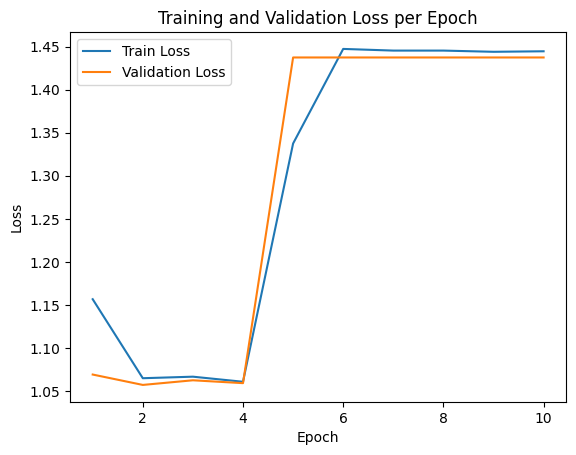

TypeError: column_stack() takes 1 positional argument but 3 were given

In [40]:
import matplotlib.pyplot as plt
# Define Loss and Optimizer

lr = .001

pos_weight = torch.tensor((y_true == 0).sum() / (y_true == 1).sum(), dtype=torch.float32).to(device)
print(pos_weight)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.SGD(model.parameters(), 
#                          lr=lr, 
#                          momentum=0.9, 
#                          weight_decay=0.0005)

# Tracking loss values
train_losses = []
val_losses = []

# Path to save the checkpoint
checkpoint_path = save_dir+"roi_finder_checkpoint"
checkpoint_path_extension=".pth"

# Check if a checkpoint exists and load it
if os.path.exists(checkpoint_path + checkpoint_path_extension):
    checkpoint = torch.load(checkpoint_path + checkpoint_path_extension)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    print(f"Resuming training from epoch {start_epoch}...")
else:
    start_epoch = 0
    print("Starting training from scratch...")

min_val_loss = 100
min_val_loss_epoch = -1

# Training loop
num_epochs = 10
for epoch in range(start_epoch, num_epochs):
    model.train()
    total_loss = 0

    for batch_X, batch_Y in train_loader:
        batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X)

        loss = criterion(outputs, batch_Y)  # No need to squeeze for 2D output

        # print out loss during training 
        
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation step
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_X, batch_Y in val_loader:
            batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_Y)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(checkpoint, checkpoint_path+checkpoint_path_extension) #Checkpoint for restarting training
    torch.save(checkpoint, checkpoint_path+"_"+str(epoch+1)+checkpoint_path_extension) #Storing all checkpoints
    print(f"Checkpoint saved at epoch {epoch + 1}")

    if avg_val_loss < min_val_loss:
        min_val_loss = avg_val_loss
        min_val_loss_epoch = epoch+1
        torch.save(checkpoint, checkpoint_path+"_min"+checkpoint_path_extension)

# Plot training and validation loss
fig = plt.figure()
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.show()
fig.savefig(save_dir+"Loss.png", dpi=fig.dpi)

# Save the trained model
torch.save(model.state_dict(), save_dir+"roi_finder.pth")

#Save training and validation loss in a CSV
table=np.column_stack((np.arange(num_epochs)+1,train_losses, val_losses))
np.savetxt(save_dir+"loss_curve.csv", table, delimiter=',', header="Epoch,Train_Loss,Validation_Loss", comments="")
del table

# Save metadata in a text file
with open(save_dir+"training_details.txt", 'w') as output:
    output.write("Model: "+str(model_index)+'\n')
    output.write("Kernel Size: "+str(kernel_size)+'\n')
    output.write("Activation Function: "+activation+'\n')
    output.write("Loss: "+"BCEWithLogitsLoss, weighted"+'\n')
    output.write("Optimizer: "+"Adam"+'\n')
    output.write("Learning Rate: "+str(lr)+'\n')
    output.write("Batch Size: "+str(batch_size)+'\n')
    output.write("Number of training events: "+str(train_size)+'\n')
    output.write("Minimum validation loss epoch: "+str(min_val_loss_epoch))

In [14]:
## Time to evaluate the performance of the model ##

In [51]:
#Load the ROI finder and put it in evaluation mode
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#roi_finder = torch.load("roi_finder.pth", map_location=device)
#roi_finder.eval()
#model.eval()

if os.path.exists(checkpoint_path + checkpoint_path_extension):
    checkpoint = torch.load(checkpoint_path+"_min"+checkpoint_path_extension)
    model.load_state_dict(checkpoint['model_state_dict'])

roi_finder = model
roi_finder.eval()

/tmp/ipykernel_783/540801541.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path+"_min"+checkpoint_path_extension)


ROIFinder2D(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (upconv1): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (upconv2): ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (upconv3): ConvTranspose2d(32, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (final_conv): Conv2d(16, 1, kernel_size=(1, 1), stride=(1, 1))
)

In [59]:
y_true_list = []
y_pred_list = []

# Set the model to evaluation mode
roi_finder.eval()

with torch.no_grad():  # Disable gradient computation for inference
    for X_batch, Y_batch in test_loader:
        X_batch = X_batch.to(device)  # Move to GPU if available
        Y_batch = Y_batch.to(device)

        # Get model predictions (logits) - Shape: (batch_size, 1, 240, 2128)
        Y_pred_batch = roi_finder(X_batch)

        # Apply threshold to get binary predictions
        Y_pred_binary = (Y_pred_batch > 0.5).cpu().numpy().astype(np.uint8)  # Convert to numpy

        # Store true and predicted values
        y_true_list.append(Y_batch.cpu().numpy().astype(np.uint8))
        y_pred_list.append(Y_pred_binary)

# Concatenate all batches along the first axis
y_true = np.concatenate(y_true_list, axis=0)  # Shape: (num_test_samples, 1, 240, 2128)
y_pred = np.concatenate(y_pred_list, axis=0)  # Shape: (num_test_samples, 1, 240, 2128)

#Save y_pred:
np.save(save_dir+"roi_pred_CNN.npy",np.squeeze(y_pred))

In [53]:
print(np.shape(y_true))
print(np.shape(y_pred))

(150, 1, 240, 2128)
(150, 1, 240, 2128)


In [54]:
y_true_flat = y_true.flatten()  # Shape: (num_test_samples * 2128,)
y_pred_flat = y_pred.flatten()  # Shape: (num_test_samples * 2128,)

In [55]:
print(np.shape(y_true_flat))
print(np.shape(y_pred_flat))

(76608000,)
(76608000,)


In [56]:
from sklearn.metrics import precision_recall_curve, confusion_matrix, f1_score, precision_score, recall_score

precision = precision_score(y_true_flat, y_pred_flat)
recall = recall_score(y_true_flat, y_pred_flat)
f1 = f1_score(y_true_flat, y_pred_flat)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true_flat, y_pred_flat)
print("Confusion Matrix:\n", cm)

#Write this to an output file
with open(save_dir+"training_results.txt", 'w') as output:
    output.write(f"Precision: {precision:.4f}"+'\n')
    output.write(f"Recall: {recall:.4f}"+'\n')
    output.write(f"F1 Score: {f1:.4f}"+'\n')
    output.write("Confusion Matrix"+'\n')
    output.write('\n'.join('\t'.join('%0.3f' %x for x in y) for y in cm))

Precision: 0.0038
Recall: 0.9705
F1 Score: 0.0076
Confusion Matrix:
 [[75961284   644172]
 [      75     2469]]


In [57]:
def iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    return intersection / union if union > 0 else 0

iou_score = iou(y_true_flat, y_pred_flat)
print(f"IoU Score: {iou_score:.4f}")

IoU Score: 0.0038


In [11]:
## Visualize evaluation ##

In [14]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable


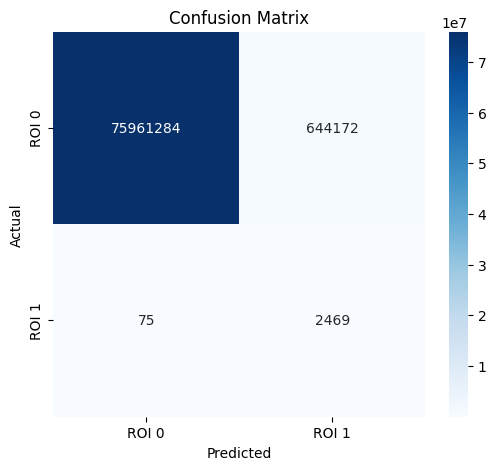

In [58]:
import seaborn as sns
# --- Confusion Matrix Visualization ---
fig = plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["ROI 0", "ROI 1"], yticklabels=["ROI 0", "ROI 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
fig.savefig(save_dir+"Confusion.png", dpi=fig.dpi)

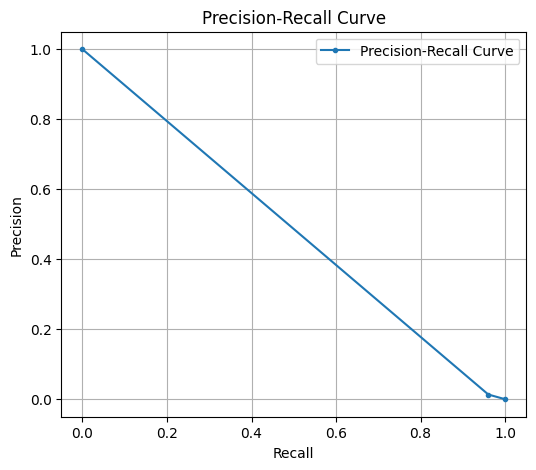

In [23]:
from sklearn.metrics import precision_recall_curve, confusion_matrix, f1_score, precision_score, recall_score
# --- Precision-Recall Curve ---
precisions, recalls, thresholds = precision_recall_curve(y_true_flat, y_pred_flat)

plt.figure(figsize=(6,5))
plt.plot(recalls, precisions, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()


In [18]:
# --- IoU Calculation and Visualization ---
def iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    return intersection / union if union > 0 else 0

iou_score = iou(y_true_flat, y_pred_flat)
print(f"IoU Score: {iou_score:.4f}")

IoU Score: 0.0000


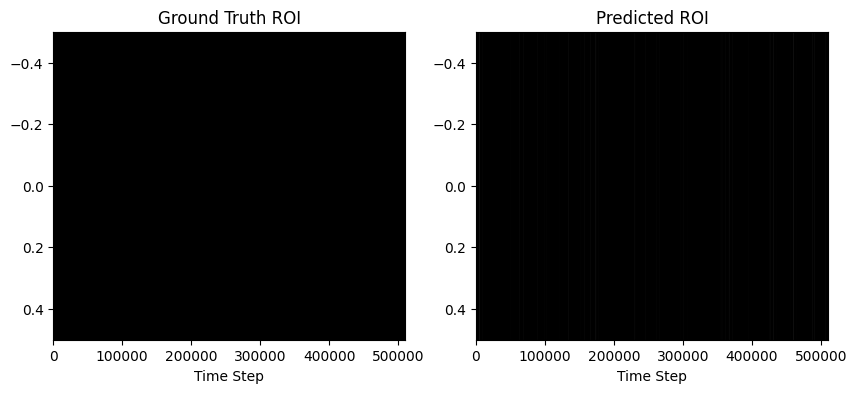

In [24]:
# --- Visualizing an Example ROI ---
sample_idx = np.random.randint(len(y_true))  # Pick a random sample
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(y_true[sample_idx, 0, :].reshape(1, -1), cmap="gray", aspect="auto")
plt.title("Ground Truth ROI")
plt.xlabel("Time Step")

plt.subplot(1, 2, 2)
plt.imshow(y_pred[sample_idx, 0, :].reshape(1, -1), cmap="gray", aspect="auto")
plt.title("Predicted ROI")
plt.xlabel("Time Step")

plt.show()

In [ ]:
# Autoencoder #

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=5, stride=2, padding=2),  # Output: (16, 1064)
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=5, stride=2, padding=2), # Output: (32, 532)
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=5, stride=2, padding=2), # Output: (64, 266)
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(64, 32, kernel_size=5, stride=2, padding=2, output_padding=1), # Output: (32, 532)
            nn.ReLU(),
            nn.ConvTranspose1d(32, 16, kernel_size=5, stride=2, padding=2, output_padding=1), # Output: (16, 1064)
            nn.ReLU(),
            nn.ConvTranspose1d(16, 1, kernel_size=5, stride=2, padding=2, output_padding=1), # Output: (1, 2128)
            nn.Tanh()  # Normalize output between -1 and 1
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize the autoencoder model
autoencoder = Autoencoder().to(device)

In [ ]:
# Input: noise+signal, Output: clean signal
X_autoencoder = noise_data.reshape(num_events * num_channels, 1, num_timesteps)
Y_autoencoder = signal_data.reshape(num_events * num_channels, 1, num_timesteps)

# Define dataset
autoencoder_dataset = ROIDataset(X_autoencoder, Y_autoencoder)

# Train-validation-test split
train_size = int(0.7 * len(autoencoder_dataset))
val_size = int(0.15 * len(autoencoder_dataset))
test_size = len(autoencoder_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(autoencoder_dataset, [train_size, val_size, test_size])

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Track loss values
train_losses = []
val_losses = []

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    autoencoder.train()
    total_loss = 0

    for batch_X, batch_Y in train_loader:
        batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)

        optimizer.zero_grad()
        outputs = autoencoder(batch_X)

        loss = criterion(outputs, batch_Y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation step
    autoencoder.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_X, batch_Y in val_loader:
            batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)
            outputs = autoencoder(batch_X)
            loss = criterion(outputs, batch_Y)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

# Plot training and validation loss
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Autoencoder Training and Validation Loss per Epoch")
plt.legend()
plt.show()

# Save the trained model
torch.save(autoencoder.state_dict(), "autoencoder.pth")